# Reproducing Facebook Freindship Networks

## Load the data

In [1]:
import scipy.io
import networkx as nx

In [2]:
A = scipy.io.loadmat('Oberlin44.mat')
B = scipy.io.loadmat('Rochester38.mat')

## Create a NetworkX graph from the adjacency matrix

In [3]:
GraphA = nx.Graph(A['A'], name="A")
GraphB = nx.Graph(B['A'], name="B")

In [4]:
print(nx.info(GraphA))
print()
print(nx.info(GraphB))
print()

Name: A
Type: Graph
Number of nodes: 2920
Number of edges: 89912
Average degree:  61.5836

Name: B
Type: Graph
Number of nodes: 4563
Number of edges: 161404
Average degree:  70.7447



## Enrich the nodes with the data in `local_info`

In [5]:
class Counter():
    count = 0
    
    def __init__(self, init=1):
        self.count = init-1
    
    def __call__(self):
        self.count += 1
        return self.count

In [6]:
def setNodeAttributes(graph, data):
    attributes = {}
    counter = Counter(0)
    for row in data:
        attributes[counter()] = {"major":  int(row[2]),
                                 "dorm":   int(row[4]),
                                 "year":   int(row[5])
                                }
    nx.set_node_attributes(graph, attributes)

In [7]:
setNodeAttributes(GraphA, A['local_info'])
setNodeAttributes(GraphB, B['local_info'])

## Cleanup the data
- `year` less than 2005
- other missing data?

In [8]:
import collections

def summary(values):
    counter = collections.Counter(sorted(values))
    print("{0:12s} {1:12s}".format("Value", "Frequency"))
    print("------------ ------------")
    for c in [c for c in counter.items()]: print("{0:12d} {1:12d}".format(c[0], c[1]))

In [9]:
summary(nx.get_node_attributes(GraphA, "year").values())

Value        Frequency   
------------ ------------
           0          440
        1967            1
        1973            1
        1993            1
        1995            1
        1998            1
        1999            1
        2000            1
        2001            2
        2002            7
        2003           18
        2004           94
        2005          387
        2006          476
        2007          513
        2008          589
        2009          363
        2010           24


In [10]:
summary(nx.get_node_attributes(GraphB, "year").values())

Value        Frequency   
------------ ------------
           0          418
        1901            1
        1927            1
        1975            1
        1978            1
        1982            1
        1989            1
        1995            1
        1996            2
        2000            1
        2001            2
        2002            7
        2003           29
        2004          131
        2005          615
        2006          764
        2007          811
        2008          908
        2009          860
        2010            8


In [11]:
def cleanup(g, attribute, low_cutoff, high_cutoff, replacement = 0):
    values = nx.get_node_attributes(g, attribute)
    for value in values.items():
        if value[1] < low_cutoff or value[1] > high_cutoff: 
            values[value[0]] = replacement
    nx.set_node_attributes(g, values, name = attribute)

In [12]:
cleanup(GraphA, "year", 2005, 2009, 0)
cleanup(GraphB, "year", 2005, 2009, 0)

In [13]:
summary(nx.get_node_attributes(GraphA, "year").values())

Value        Frequency   
------------ ------------
           0          592
        2005          387
        2006          476
        2007          513
        2008          589
        2009          363


In [14]:
summary(nx.get_node_attributes(GraphB, "year").values())

Value        Frequency   
------------ ------------
           0          605
        2005          615
        2006          764
        2007          811
        2008          908
        2009          860


## Perform Louvain clustering
https://en.wikipedia.org/wiki/Louvain_Modularity


In [15]:
import community as louvain

In [16]:
CommunityLouvainA = louvain.best_partition(GraphA)
CommunityLouvainA = louvain.best_partition(GraphB)

In [17]:
nx.set_node_attributes(GraphA, CommunityLouvainA, "c-louvain")
nx.set_node_attributes(GraphB, CommunityLouvainA, "c-louvain")

In [18]:
summary(nx.get_node_attributes(GraphA, "c-louvain").values())

Value        Frequency   
------------ ------------
           0          503
           1          877
           2          530
           3          500
           4          280
           5           93
           6            2
           7          128
           8            7


In [19]:
summary(nx.get_node_attributes(GraphB, "c-louvain").values())

Value        Frequency   
------------ ------------
           0          805
           1         1346
           2          826
           3          783
           4          448
           5          146
           6            2
           7          196
           8           11


## Cluster by Categorical Variables
- year
- dorm
- major

In [20]:
def groups(values):
    _groups = {}
    counter = Counter(0)
    for value in sorted(set(values)):
        _groups[value] = counter()
    return _groups

In [21]:
def clustering(g, attribute):
    _clustering = {}
    _groups = groups(nx.get_node_attributes(g, attribute).values())
    nodes = list(g.nodes())
    for node in nodes:
        attr = g.nodes()[node][attribute]
        _clustering[node] = _groups[attr]
    return _clustering

In [22]:
nx.set_node_attributes(GraphA, clustering(GraphA, "year"), "c-year")
nx.set_node_attributes(GraphA, clustering(GraphA, "dorm"), "c-dorm")
nx.set_node_attributes(GraphA, clustering(GraphA, "major"), "c-major")

In [23]:
nx.set_node_attributes(GraphB, clustering(GraphB, "year"), "c-year")
nx.set_node_attributes(GraphB, clustering(GraphB, "dorm"), "c-dorm")
nx.set_node_attributes(GraphB, clustering(GraphB, "major"), "c-major")

## Compare Clustering

In [24]:
from clusim.clustering import Clustering, print_clustering
import clusim.sim as sim

DendroPY not supported.


In [25]:
def membership(d):
    _membership = {}
    for key in d.keys():
        value = d[key]
        _membership[key] = [value]
    return _membership

In [26]:
ClusteringLouvainA = Clustering(elm2clu_dict = membership(nx.get_node_attributes(GraphA, "c-louvain")))
ClusteringYearA    = Clustering(elm2clu_dict = membership(nx.get_node_attributes(GraphA, "c-year")))
ClusteringDormA    = Clustering(elm2clu_dict = membership(nx.get_node_attributes(GraphA, "c-dorm")))
ClusteringMajorA   = Clustering(elm2clu_dict = membership(nx.get_node_attributes(GraphA, "c-major")))

In [27]:
ClusteringLouvainB = Clustering(elm2clu_dict = membership(nx.get_node_attributes(GraphB, "c-louvain")))
ClusteringYearB    = Clustering(elm2clu_dict = membership(nx.get_node_attributes(GraphB, "c-year")))
ClusteringDormB    = Clustering(elm2clu_dict = membership(nx.get_node_attributes(GraphB, "c-dorm")))
ClusteringMajorB   = Clustering(elm2clu_dict = membership(nx.get_node_attributes(GraphB, "c-major")))

Using **Jaccard Index**, compare the extracted clustering (Louvain) and the categorical clustering

In [28]:
print("{0:8s}\t{1:8s}\t{2:8s}\t{3:8s}".format("School", "Year", "Dorm", "Major"))
print("--------\t--------\t--------\t--------")
print("{0:8s}\t{1:-2.8f}\t{2:2.8f}\t{3:2.8f}".format("A", 
                                                     sim.jaccard_index(ClusteringLouvainA, ClusteringYearA), 
                                                     sim.jaccard_index(ClusteringLouvainA, ClusteringDormA), 
                                                     sim.jaccard_index(ClusteringLouvainA, ClusteringMajorA)))
print("{0:8s}\t{1:-2.8f}\t{2:2.8f}\t{3:2.8f}".format("B", 
                                                     sim.jaccard_index(ClusteringLouvainB, ClusteringYearB), 
                                                     sim.jaccard_index(ClusteringLouvainB, ClusteringDormB), 
                                                     sim.jaccard_index(ClusteringLouvainB, ClusteringMajorB)))

School  	Year    	Dorm    	Major   
--------	--------	--------	--------
A       	0.10094517	0.11197451	0.04981343
B       	0.30093665	0.17459892	0.05471750


Using **element-centric similarity measure**, compare the extracted clustering (Louvain) and the categorical clustering

In [29]:
print("{0:8s}\t{1:8s}\t{2:8s}\t{3:8s}".format("School", "Year", "Dorm", "Major"))
print("--------\t--------\t--------\t--------")
print("{0:8s}\t{1:-2.8f}\t{2:2.8f}\t{3:2.8f}".format("A", 
                                                     sim.element_sim(ClusteringLouvainA, ClusteringYearA, alpha = 0.9), 
                                                     sim.element_sim(ClusteringLouvainA, ClusteringDormA, alpha = 0.9), 
                                                     sim.element_sim(ClusteringLouvainA, ClusteringMajorA, alpha = 0.9)))
print("{0:8s}\t{1:-2.8f}\t{2:2.8f}\t{3:2.8f}".format("B", 
                                                     sim.element_sim(ClusteringLouvainB, ClusteringYearB, alpha = 0.9), 
                                                     sim.element_sim(ClusteringLouvainB, ClusteringDormB, alpha = 0.9), 
                                                     sim.element_sim(ClusteringLouvainB, ClusteringMajorB, alpha = 0.9)))

School  	Year    	Dorm    	Major   
--------	--------	--------	--------
A       	0.14994183	0.10602260	0.05905116
B       	0.40408177	0.21657261	0.07796667


In [30]:
def cooccurence(c1, c2):
    N11, N10, N01, N00 = sim.count_pairwise_cooccurence(c1, c2)
    print(N11,
        "element pairs assigned to the same clusters in both clusterings")
    print(N10,
        "element pairs assigned to the same clusters in clustering1, but "
        "different clusters in clustering2")
    print(N01, "element pairs assigned to different clusters in "
               "clustering1, but the same clusters in clustering2")
    print(N00, "element pairs assigned to different clusters in both "
               "clusterings")

In [31]:
cooccurence(ClusteringLouvainA, ClusteringYearA)

143006.0 element pairs assigned to the same clusters in both clusterings
683796.0 element pairs assigned to the same clusters in clustering1, but different clusters in clustering2
589868.0 element pairs assigned to different clusters in clustering1, but the same clusters in clustering2
2845070.0 element pairs assigned to different clusters in both clusterings


In [32]:
cooccurence(ClusteringLouvainB, ClusteringYearB)

873970.0 element pairs assigned to the same clusters in both clusterings
1131582.0 element pairs assigned to the same clusters in clustering1, but different clusters in clustering2
898614.0 element pairs assigned to different clusters in clustering1, but the same clusters in clustering2
7504037.0 element pairs assigned to different clusters in both clusterings


## Save to GEXF 

In [33]:
nx.write_gexf(GraphA, "A.gexf")
nx.write_gexf(GraphB, "B.gexf")

## Visualizations
using Gephi:
- run *Modularity*
- run *ForceAtlas 2* layout, enabling *Stringer Gravity* to keep nodes more closely compacted
- set the color of the nodes based on: Modularity Class, and then Year
- export both as PNG

### College "A"

In [34]:
%%html
<table>
<tr>
<th align="left">Modularity</th><th align="left">Year</th>
</tr>
<tr>
<td><img src="a-modularity.png", width=400, height=400></td>
<td><img src="a-year.png", width=400, height=400></td>
</tr>
</table>

Modularity,Year
,


### College "B"

In [35]:
%%html
<table>
<tr>
<th align="left">Modularity</th><th align="left">Year</th>
</tr>
<tr>
<td><img src="b-modularity.png", width=400, height=400></td>
<td><img src="b-year.png", width=400, height=400></td>
</tr>
</table>

Modularity,Year
,


# ToDo
1. try removing nodes with "missing" data?
   - year = 0
   - dorm = 0
   - major = 0
2. explore just first-year students (graduation year = 2009)
3. investigate different clustering results between Louvain computed here and Gephi's Modularity (which also is Louvain)
4. try [NetworkX community detection algorithms](https://networkx.github.io/documentation/stable/reference/algorithms/community.html)
5. try [Louvain method in graphy package](https://graphy.readthedocs.io/graphy.louvain.html)

In [36]:
import networkx as nx
import graphy
from graphy.louvain import optimize_modularity

In [42]:
GraphA_best_membership, GraphA_q = optimize_modularity(nx.to_numpy_matrix(GraphA))
GraphB_best_membership, GraphB_q = optimize_modularity(nx.to_numpy_matrix(GraphB))

In [43]:
print(GraphA_q)
print(GraphB_q)

0.3707198906435754
0.49254481481946183


In [44]:
%matplotlib inline

In [45]:
import numpy as np

# optimal distance between nodes
def odbn(g):
    result = 2*(1/np.sqrt(len(g.nodes())))
    return result

In [55]:
LayoutA = nx.spring_layout(GraphA, k=odbn(GraphA))
LayoutB = nx.spring_layout(GraphB, k=odbn(GraphA))

In [57]:
def plot(graph, layout, membership):
    graphy.plotting.plot_graph(graph, 
                               pos=layout, 
                               colors=membership, 
                               cmap="magma",
                               node_size=0.02, 
                               edgescale=0.05)

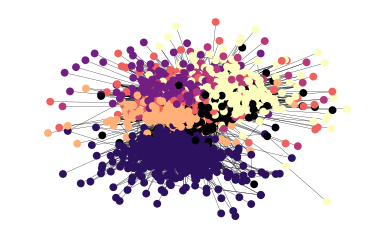

In [58]:
plot(GraphA, LayoutA, GraphA_best_membership)

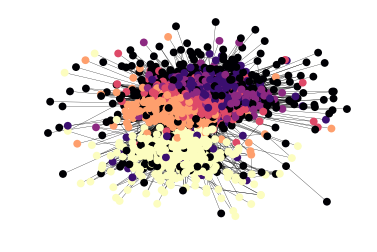

In [59]:
plot(GraphA, LayoutA, list(nx.get_node_attributes(GraphA, "c-year").values()))

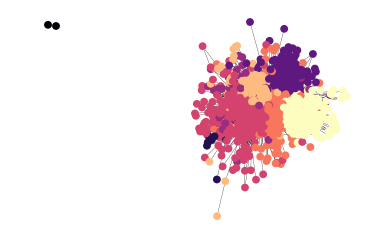

In [60]:
plot(GraphB, LayoutB, GraphB_best_membership)

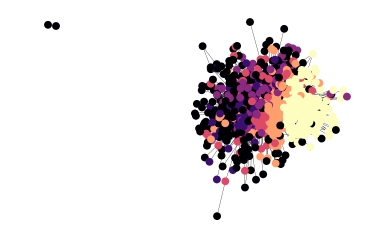

In [61]:
plot(GraphB, LayoutB, list(nx.get_node_attributes(GraphB, "c-year").values()))